<a href="https://colab.research.google.com/github/HedersonSantos/SmartHome/blob/main/seriesTemporaisLSTM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pmdarima-1.8.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.4 MB)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)


from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import LSTM
 

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [3]:
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/sample_submission.csv

--2022-05-30 15:49:42--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360467 (352K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 352.02K  --.-KB/s    in 0.003s  

2022-05-30 15:49:42 (118 MB/s) - ‘train.csv’ saved [360467/360467]

--2022-05-30 15:49:42--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170613 (167K) [text/plain]
Saving to: ‘test

In [4]:
def plotaSeries(treino, teste, predito):
  if type(treino) == pd.core.series.Series:
    treino.plot(legend=True,label='Treino')
  if type(teste) == pd.core.series.Series:
    teste.plot(legend=True,label='Teste',figsize=(16,8))
  if  type(predito)==pd.core.series.Series:
    predito.plot(legend=True) 
  else:
    for p in predito.columns:
      predito[p].plot(legend=True)

In [84]:
df_treino = pd.read_csv('train.csv')
df_treino['data_hora'] = df_treino.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_treino = df_treino.sort_values(by='data_hora')
df_treino = df_treino.set_index('data_hora')
#idx = pd.date_range(start=df_treino.index.min(), end=df_treino.index.max(),  freq='0h15min')
#df_treino= df_treino.reindex(idx)
df_treino = df_treino['Indoor_temperature_room'].resample('H').mean().iloc[1: , ]
df_treino.fillna(method='ffill', inplace=True)

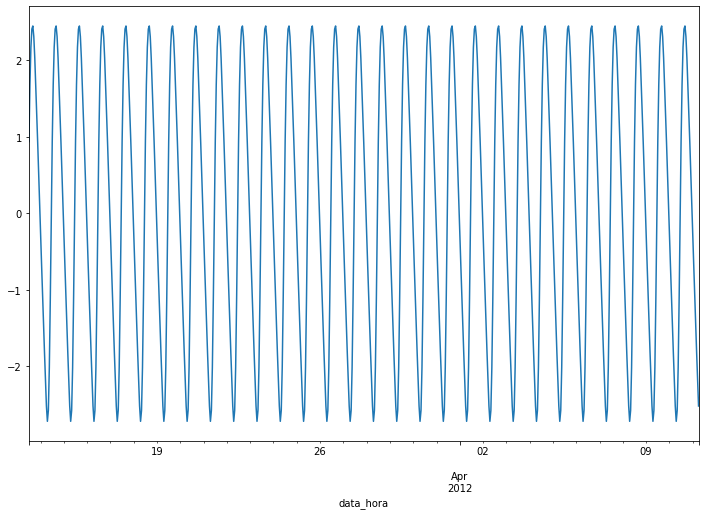

In [46]:
results = seasonal_decompose(df_treino)
results.seasonal[:1000].plot(figsize = (12,8));


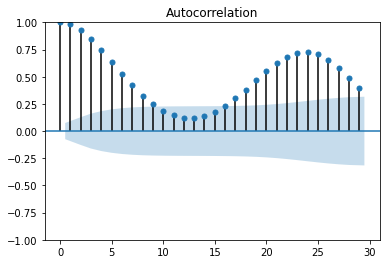

In [48]:
plot_acf(df_treino)
plt.show();

In [50]:
min(df_treino.index), max(df_treino.index)

(Timestamp('2012-03-13 12:00:00', freq='H'),
 Timestamp('2012-04-11 06:00:00', freq='H'))

In [85]:
dfx = pd.DataFrame(df_treino).reset_index()
dfx['data'] =  dfx['data_hora'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [86]:
dfx.groupby('data')['data_hora'].count().reset_index().sort_values('data')

,data,data_hora
0,2012-03-13,12
1,2012-03-14,24
2,2012-03-15,24
3,2012-03-16,24
4,2012-03-17,24
5,2012-03-18,24
6,2012-03-19,24
7,2012-03-20,24
8,2012-03-21,24
9,2012-03-22,24


In [78]:
dfx.columns

Index(['data_hora', 'Indoor_temperature_room', 'data'], dtype='object')

In [87]:
df_treino = df_treino[df_treino.index.strftime('%Y-%m-%d') !="13/03/2012"]
df_treino = df_treino[df_treino.index.strftime('%Y-%m-%d') !="11/04/2012"]

In [91]:
df_treino.head(5)

data_hora
2012-03-13 12:00:00    18.587525
2012-03-13 13:00:00    19.628500
2012-03-13 14:00:00    20.462000
2012-03-13 15:00:00    21.958325
2012-03-13 16:00:00    23.076000
Freq: H, Name: Indoor_temperature_room, dtype: float64

In [92]:
#dividindo a amostra em treino e teste
dfTreino = df_treino[df_treino.index < datetime(2012,4,8,0,0)]
dfTeste = df_treino[df_treino.index >= datetime(2012,4,8,0,0)]
print(dfTreino.shape, dfTeste.shape)
print(min(dfTreino.index), max(dfTreino.index))
print(min(dfTeste.index), max(dfTeste.index))

(612,) (79,)
2012-03-13 12:00:00 2012-04-07 23:00:00
2012-04-08 00:00:00 2012-04-11 06:00:00


In [93]:
#padronizando os valores de 'confirmed' para o dataset de treino e teste - colocando todos os exemplos na mesma escala
scaler = MinMaxScaler()
scaler.fit(dfTreino)

scaled_train = scaler.transform(dfTreino)
scaled_test = scaler.transform(dfTeste)

plt.hist(scaled_train)


ValueError: ignored

In [13]:
# gerando as entradas para a rede neural - (o gerador)

n_input = 96
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=96)
len(generator)

24

In [14]:
#definindo o modelo e imprimindo a arquitetura
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse' )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 162,601
Trainable params: 162,201
Non-trainable params: 400
_________________________________________________________________


In [15]:
model.fit(generator,epochs=5)

Epoch 1/5
24/24 [==============================] - 18s 447ms/step - loss: 0.2028
Epoch 2/5
24/24 [==============================] - 7s 263ms/step - loss: 0.0429
Epoch 3/5
24/24 [==============================] - 4s 154ms/step - loss: 0.0307
Epoch 4/5
24/24 [==============================] - 4s 155ms/step - loss: 0.0297
Epoch 5/5
24/24 [==============================] - 4s 153ms/step - loss: 0.0288


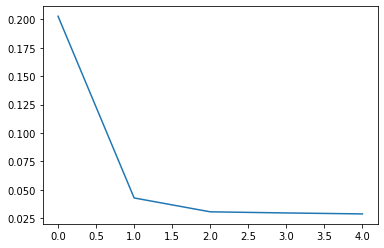

In [16]:
#verificando a descida do grandiente com a função loss = mse
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [17]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(scaled_test.shape[0]):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
true_predictions = scaler.inverse_transform(test_predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


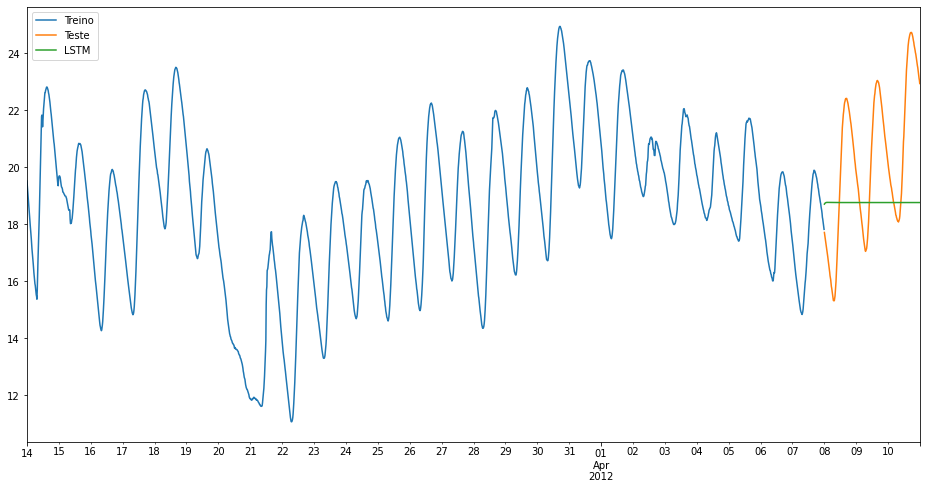

In [18]:
dfTeste['LSTM'] = true_predictions
plotaSeries(dfTreino['Indoor_temperature_room'], dfTeste['Indoor_temperature_room'], dfTeste['LSTM'])